In [1]:
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
pd.options.mode.chained_assignment = None

In [2]:
%matplotlib inline

In [4]:
train = pd.read_csv('Desktop/BikeSharingDemand/train.csv')
test = pd.read_csv('Desktop/BikeSharingDemand/test.csv')
submit = pd.read_csv('Desktop/BikeSharingDemand/sampleSubmission.csv')

In [5]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


# Feature Engineering

In [8]:
print ("Shape Of The Before Ouliers: ",train.shape)
train = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 
print ("Shape Of The After Ouliers: ",train.shape)

Shape Of The Before Ouliers:  (10886, 12)
Shape Of The After Ouliers:  (10739, 12)


In [9]:
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)

data

/Users/yuanhanlei/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday,date,hour,year,weekday,month
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0000,0,2011-01-01,0,2011,5,1
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0000,0,2011-01-01,1,2011,5,1
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0000,0,2011-01-01,2,2011,5,1
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0000,0,2011-01-01,3,2011,5,1
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0000,0,2011-01-01,4,2011,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17227,12.880,NaN,NaN,2012-12-31 19:00:00,0,60,NaN,1,10.66,2,11.0014,1,2012-12-31,19,2012,0,12
17228,12.880,NaN,NaN,2012-12-31 20:00:00,0,60,NaN,1,10.66,2,11.0014,1,2012-12-31,20,2012,0,12
17229,12.880,NaN,NaN,2012-12-31 21:00:00,0,60,NaN,1,10.66,1,11.0014,1,2012-12-31,21,2012,0,12
17230,13.635,NaN,NaN,2012-12-31 22:00:00,0,56,NaN,1,10.66,1,8.9981,1,2012-12-31,22,2012,0,12


[Text(0.5, 0, 'windspeed'), Text(0.5, 1.0, 'distribution of windspeed')]

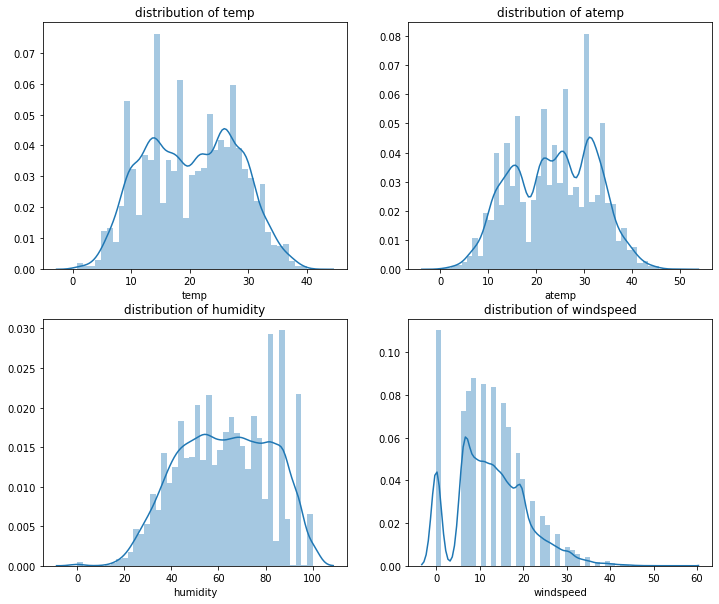

In [10]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.distplot(data["temp"],ax=axes[0][0])
sns.distplot(data["atemp"],ax=axes[0][1])
sns.distplot(data["humidity"],ax=axes[1][0])
sns.distplot(data["windspeed"],ax=axes[1][1])

axes[0][0].set(xlabel='temp',title="distribution of temp")
axes[0][1].set(xlabel='atemp',title="distribution of atemp")
axes[1][0].set(xlabel='humidity',title="distribution of humidity")
axes[1][1].set(xlabel='windspeed',title="distribution of windspeed")

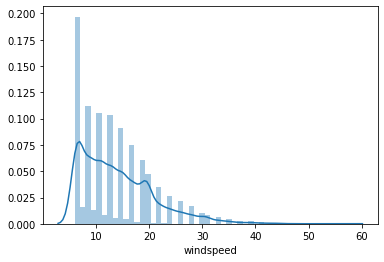

In [13]:
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"]!=0]
rfModel_wind = RandomForestRegressor(n_estimators=1000,random_state=42)
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0.loc[:,"windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index',inplace=True,axis=1)

sns.distplot(data["windspeed"])

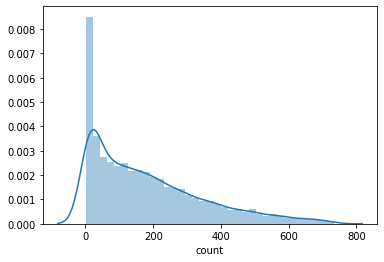

In [14]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsLog = np.log(yLabels)

dropFeatures = ['casual',"count","datetime","date","registered"]
dataTrain  = dataTrain.drop(dropFeatures,axis=1)
dataTest  = dataTest.drop(dropFeatures,axis=1)

sns.distplot(yLabels)

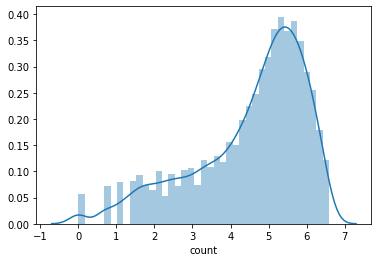

In [16]:
sns.distplot(yLabelsLog)

In [17]:
rfModel = RandomForestRegressor(n_estimators=1000,random_state=42)
yLabelsLog = np.log(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)

In [18]:
predsTest = rfModel.predict(X= dataTest)
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsTest)]
    })
submission.to_csv('bike_predictions_RF.csv', index=False)